X.9.4

Сингулярно-возмущенная система — модель двухлампового
генератора Фрюгауфа:
$$
\begin{cases}
\epsilon*x'_{1} = -\alpha * (y_{1} - y_{2}) + \phi(x_{1}) - x_{2} \\
\epsilon*x'_{2} =  \alpha * (y_{1} - y_{2}) + \phi(x_{2}) - x_{1} \\
y'_{1} = x_{1} \\
y'_{2} = x_{2} \\
\end{cases}
$$

Здесь $\alpha > 0 $ -- константа порядка единицы, функция $\phi(u) = -tg(\pi*u / 2)$, 
$x_{1}(0)=x_{2}(0)=0$, $y_{1}=2$, $y_{2}=0$, $T_{k}=20$, $\epsilon=10^{-3},10^{-6}$

In [167]:
import numpy as np
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

In [182]:
# Constants
alpha = 1
epsilons = [1e-3, 1e-6]  # We'll solve for both values of epsilon
T_k = 20
dt = 0.001  # time step
N = int(T_k / dt)  # number of steps

time = np.linspace(0, T_k, N)
phi = lambda u: -np.tan(np.pi * u / 2)  # phi function

# Define the system of ODEs
def odes_system(t, vars, epsilon):
    x1, x2, y1, y2 = vars
    dx1_dt = (-alpha * (y1 - y2) + phi(x1) - x2) / epsilon
    dx2_dt = (alpha * (y1 - y2) + phi(x2) - x1) / epsilon
    dy1_dt = x1
    dy2_dt = x2
    return np.array([dx1_dt, dx2_dt, dy1_dt, dy2_dt])

## BDF 4 from library.

Воспользуемся решением системы из библиотеки, чтобы было с чем сравнивать результаты


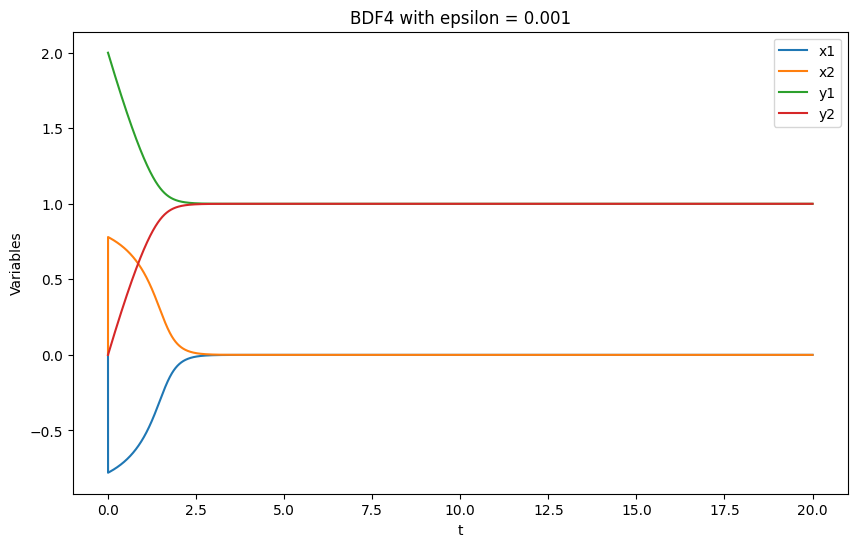

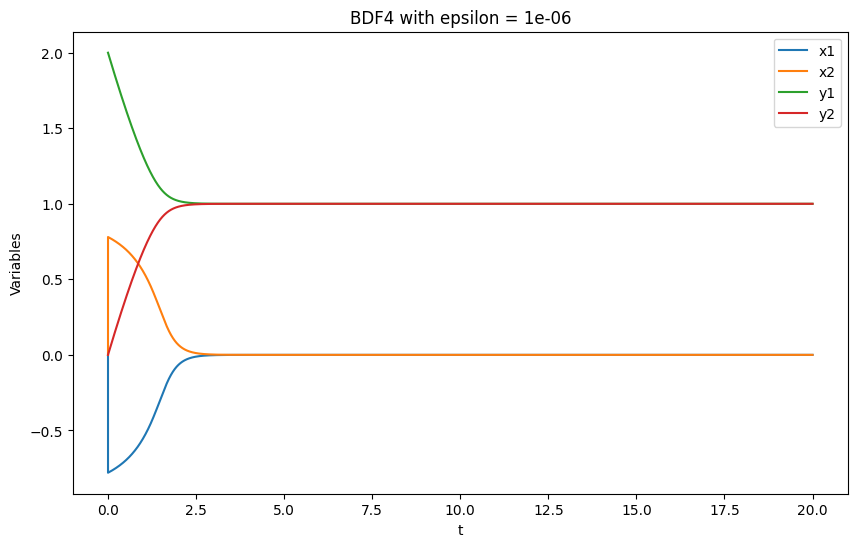

In [183]:

init_values = [0, 0, 2, 0]
t_span = (0, T_k)
sol_dicts = []

for epsilon in epsilons:
    sol = solve_ivp(odes_system, t_span, init_values, method='BDF', args=(epsilon,), dense_output=True)
    sol_dicts.append(sol)

# Plotting the solution for each epsilon
time = np.linspace(0, T_k, N)
for i, epsilon in enumerate(epsilons):
    plt.figure(figsize=(10, 6))
    sol = sol_dicts[i].sol(time)
    plt.plot(time, sol[0], label='x1')
    plt.plot(time, sol[1], label='x2')
    plt.plot(time, sol[2], label='y1')
    plt.plot(time, sol[3], label='y2')
    plt.title(f'BDF4 with epsilon = {epsilon}')
    plt.xlabel('t')
    plt.ylabel('Variables')
    plt.legend()
    plt.show()

## 1) Неявные методы типа Рунге-Кутты 

Можно заметить, что метод Рунге-Кутты, при очень маленьком epsilon (10e-6) сходится только при очень маленьком шаге, что занимает значительное время вычислений (2 минуты 14 секунд)

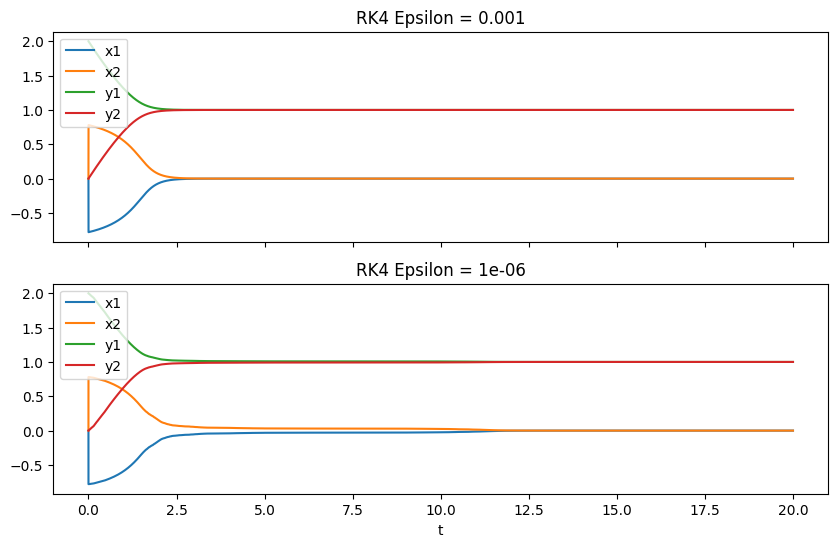

In [186]:
dt = 0.0005  # time step
N = int(T_k / dt)  # number of steps


# IRK4 method (implicit)
def IRK4_step(vars, t, dt, epsilon):
    def equations(z):
        k1, k2, k3, k4 = z[:4], z[4:8], z[8:12], z[12:]
        y1 = vars + dt/2 * (k1 + k2)
        y2 = vars + dt/2 * (k2 + k3)
        y3 = vars + dt * k3
        f1 = odes_system(t, vars + dt/6 * (k1 + 2*k2 + 2*k3 + k4), epsilon) - k1
        f2 = odes_system(t + dt/2, y1, epsilon) - k2
        f3 = odes_system(t + dt/2, y2, epsilon) - k3
        f4 = odes_system(t + dt, y3, epsilon) - k4
        return np.concatenate([f1, f2, f3, f4])

    # Initial guess for the fsolve (Euler method)
    initial_guess = np.tile(odes_system(t, vars, epsilon), 4) * dt
    solution = fsolve(equations, initial_guess)
    k1, k2, k3, k4 = solution[:4], solution[4:8], solution[8:12], solution[12:]
    next_vars = vars + dt/6 * (k1 + 2*k2 + 2*k3 + k4)
    return next_vars

# Solve the system for each epsilon
solutions = {}
for epsilon in epsilons:
    time = np.linspace(0, T_k, N)
    x1, x2, y1, y2 = np.zeros(N), np.zeros(N), np.zeros(N), np.zeros(N)
    x1[0], x2[0], y1[0], y2[0] = 0, 0, 2, 0
    vars = np.array([0, 0, 2, 0])
    for i in range(1, N):
        vars = IRK4_step(vars, time[i-1], dt, epsilon)
        x1[i], x2[i], y1[i], y2[i] = vars
    solutions[epsilon] = (time, x1, x2, y1, y2)

# Plotting
fig, axes = plt.subplots(len(epsilons), 1, figsize=(10, 6), sharex=True)
if not isinstance(axes, np.ndarray):
    axes = [axes]
for ax, epsilon in zip(axes, epsilons):
    time, x1, x2, y1, y2 = solutions[epsilon]
    ax.plot(time, x1, label='x1')
    ax.plot(time, x2, label='x2')
    ax.plot(time, y1, label='y1')
    ax.plot(time, y2, label='y2')
    ax.set_title(f'RK4 Epsilon = {epsilon}')
    ax.legend()
plt.xlabel('t')
plt.show()


## 2) BDF 4 порядка 

Метод расходится. Как бы я не пытался повторить 4 порядок, только если поставить минимальный шаг и ждать вечность, то ситуация разрешится

Этот же алгоритм решал задачу из прошлой лабы, где задача была жёсткая, но в случае нежёсткой задачи, он не справился


C:\Users\danii\AppData\Local\Temp\ipykernel_7512\4219921419.py:12: RuntimeWarning: overflow encountered in scalar divide
  dx1_dt = (-alpha * (y1 - y2) + phi(x1) - x2) / epsilon
C:\Users\danii\AppData\Local\Temp\ipykernel_7512\4219921419.py:13: RuntimeWarning: overflow encountered in scalar divide
  dx2_dt = (alpha * (y1 - y2) + phi(x2) - x1) / epsilon
C:\Users\danii\AppData\Local\Temp\ipykernel_7512\3920352891.py:7: RuntimeWarning: invalid value encountered in tan
  phi = lambda u: -np.tan(np.pi * u / 2)


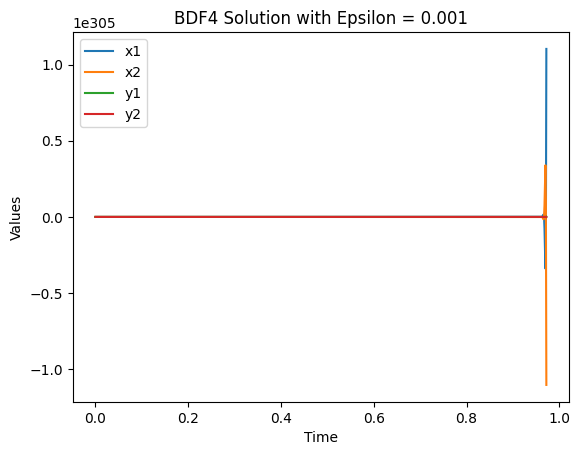

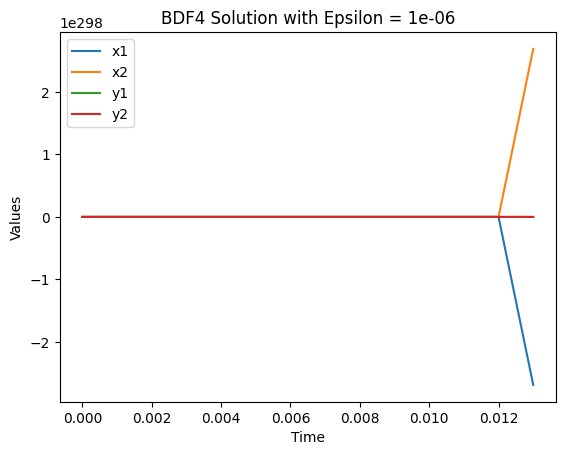

In [212]:
dt = 0.001 # time step
N = int(T_k / dt)  # number of steps


initial_conditions = np.array([0, 0, 2, 0])  


def solve_system_BDF4(odes_system, epsilon, initial_conditions, dt, N):
    y = np.zeros((N, len(initial_conditions)))
    y[:4] = np.array([initial_conditions for _ in range(4)])  # Initial steps using Euler or similar
    
    for n in range(3, N - 1):
        # Predict y[n+1] using Euler for initial guess in non-linear solver
        y_pred = y[n] + dt * odes_system(n*dt, y[n], epsilon)
        
        # Fixed-point iteration for implicit step
        for _ in range(10):  # 10 iterations should be adjusted based on tolerance
            y_guess = (25/12)*y[n] - 4*y[n-1] + 3*y[n-2] - (4/3)*y[n-3] + (1/4)*y[n-4]
            y_guess += (12*dt/25) * odes_system((n+1)*dt, y_pred, epsilon)
                        
            y_pred = y_guess  # prepare for the next iteration

        y[n+1] = y_guess
        
    return y

# Example of solving for one value of epsilon
results = []
for epsilon in epsilons:
    result = solve_system_BDF4(odes_system, epsilon, initial_conditions, dt, N)
    results.append(result)


time = np.linspace(0, T_k, N)

# Plot for each epsilon
for epsilon, result in zip(epsilons, results):
    # Assuming result is structured as [time_step, variable (x1, x2, y1, y2)]
    x1, x2, y1, y2 = result.T  # Transpose to get them by variables

    fig, ax = plt.subplots()
    ax.plot(time, x1, label='x1')
    ax.plot(time, x2, label='x2')
    ax.plot(time, y1, label='y1')
    ax.plot(time, y2, label='y2')
    ax.set_xlabel('Time')
    ax.set_ylabel('Values')
    ax.set_title(f'BDF4 Solution with Epsilon = {epsilon}')
    ax.legend()

plt.show()    

## 3) Методы Розенброка (Розенброка-Ванера)


#### Метод из библиотеки, чтобы было с чем сравнивать

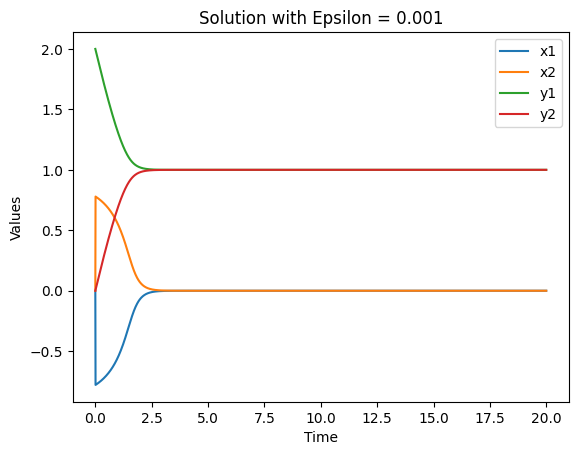

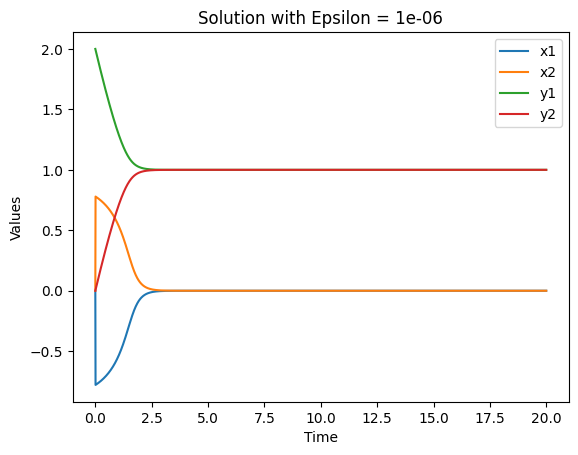

In [194]:
dt = 0.01

# Initial conditions
init_values = [0, 0, 2, 0]


results = []  # To store the solutions for different epsilons

# time array
time = np.linspace(0, T_k, int(T_k/dt))

# Solve the system for each epsilon
for epsilon in epsilons:
    sol = solve_ivp(odes_system, [0, T_k], init_values, method='Radau', t_eval=time, args=[epsilon])
    results.append((time, sol.y))  # Store the time stamps and the corresponding solutions

# Plot results
for epsilon, (time, result) in zip(epsilons, results):
    x1, x2, y1, y2 = result  # Assuming result is already in the desired shape

    fig, ax = plt.subplots()
    ax.plot(time, x1, label='x1')
    ax.plot(time, x2, label='x2')
    ax.plot(time, y1, label='y1')
    ax.plot(time, y2, label='y2')
    ax.set_xlabel('Time')
    ax.set_ylabel('Values')
    ax.set_title(f'Solution with Epsilon = {epsilon}')
    ax.legend()

plt.show()


#### Реализация Метода Розенброка

Расходится для epsilon 10e^-6

C:\Users\danii\AppData\Local\Temp\ipykernel_7512\4219921419.py:12: RuntimeWarning: overflow encountered in scalar divide
  dx1_dt = (-alpha * (y1 - y2) + phi(x1) - x2) / epsilon
C:\Users\danii\AppData\Local\Temp\ipykernel_7512\4219921419.py:13: RuntimeWarning: overflow encountered in scalar divide
  dx2_dt = (alpha * (y1 - y2) + phi(x2) - x1) / epsilon
C:\Users\danii\AppData\Local\Temp\ipykernel_7512\3920352891.py:7: RuntimeWarning: invalid value encountered in tan
  phi = lambda u: -np.tan(np.pi * u / 2)
C:\Users\danii\AppData\Local\Temp\ipykernel_7512\3611646877.py:7: RuntimeWarning: invalid value encountered in cos
  dfdx[0, 0] = (-np.pi / (2 * epsilon)) * (1 / (np.cos(np.pi * x1 / 2))**2) - 1 / epsilon
C:\Users\danii\AppData\Local\Temp\ipykernel_7512\3611646877.py:12: RuntimeWarning: invalid value encountered in cos
  dfdx[1, 1] = (-np.pi / (2 * epsilon)) * (1 / (np.cos(np.pi * x2 / 2))**2) - 1 / epsilon


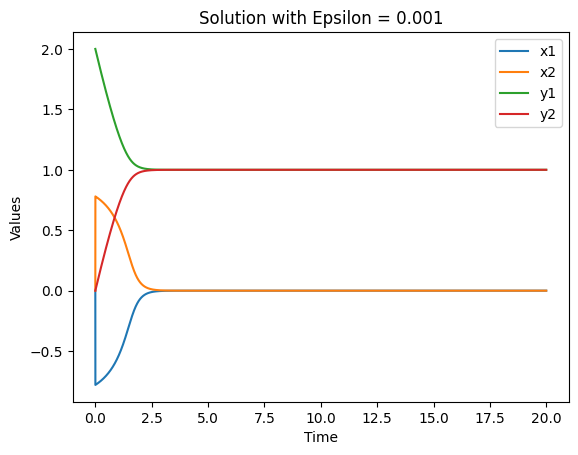

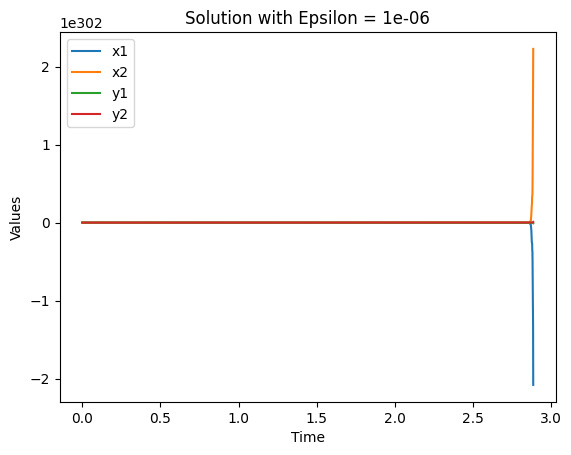

In [211]:
dt = 0.001  # time step
N = int(T_k / dt)  # number of steps

def jacobian(t, vars, epsilon):
    x1, x2, _, _ = vars
    dfdx = np.zeros((4, 4))
    dfdx[0, 0] = (-np.pi / (2 * epsilon)) * (1 / (np.cos(np.pi * x1 / 2))**2) - 1 / epsilon
    dfdx[0, 1] = -1 / epsilon
    dfdx[0, 2] = -alpha / epsilon
    dfdx[0, 3] = alpha / epsilon
    dfdx[1, 0] = -1 / epsilon
    dfdx[1, 1] = (-np.pi / (2 * epsilon)) * (1 / (np.cos(np.pi * x2 / 2))**2) - 1 / epsilon
    dfdx[1, 2] = alpha / epsilon
    dfdx[1, 3] = -alpha / epsilon
    dfdx[2, 0] = 1
    dfdx[3, 1] = 1
    return dfdx

def rosenbrock_solver(system, jac, initial_values, time, epsilon):
    vars = np.array(initial_values, dtype=float)
    dt = time[1] - time[0]
    history = np.empty((len(time), len(vars)))
    
    for i, t in enumerate(time):
        history[i] = vars
        F = system(t, vars, epsilon)
        J = jac(t, vars, epsilon)
        Gamma = J - np.eye(len(vars)) / dt
        inv_Gamma = np.linalg.inv(Gamma)
        delta = np.dot(inv_Gamma, F)
        vars -= delta  
    return history

init_values = [0, 0, 2, 0]
results = {}
time = np.linspace(0, T_k, N)

for epsilon in epsilons:
    history = rosenbrock_solver(odes_system, jacobian, init_values, time, epsilon)
    results[epsilon] = history  
    

    x1, x2, y1, y2 = history.T 
    
    fig, ax = plt.subplots()
    ax.plot(time, x1, label='x1')
    ax.plot(time, x2, label='x2')
    ax.plot(time, y1, label='y1')
    ax.plot(time, y2, label='y2')
    ax.set_xlabel('Time')
    ax.set_ylabel('Values')
    ax.set_title(f'Solution with Epsilon = {epsilon}')
    ax.legend()

plt.show()